# TP3 Ex2 Grupo 24
Gabriel Antunes a101101<br>
Guilherme Pinho a105533

Construa um “Control Flow Automaton (CFA)” que determina este programa. Identifique os locais e as transições/ramos.  Numa abordagem orientada às pré-condições  identifique os transformadores de predicados associados aos vários locais e os “switches” associados aos vários ramos.<br>
Construa em `z3` o sistema de equações que representa o comportamento deste sistema dinâmico sob o ponto de vista da prova de segurança e verifique a segurança do programa através da resolução (total ou parcial) deste sistema.

#### Import das várias biblioytecas utilizadas

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
from pysmt.shortcuts import *
from pysmt.typing import INT
from z3 import *

#### Alinea a Construir um CFA relativo ao programa do exercício anterior

In [6]:
MAX_VAL = 1000
# Construir o grafo do Control Flow Automaton (CFA)
def build_cfa():
    

    cfa = nx.DiGraph()

    # Variáveis simbólicas
    r1 = Int("r1")  # Exemplo simbólico para condição r' != 0
    r = Int("r")
    a = Int("a")
    b = Int("b")
    s = Int("s")
    t = Int("t")   

    # Estados (locais)
    cfa.add_node("Start", description="Inicialização das variáveis", annotation=And(a * s + b * t == r, And(a%r == 0, b%r == 0), a > 0, b > 0))
    cfa.add_node("Error", description="Estado de erro", annotation=BoolVal(False))
    cfa.add_node("While_Condition", description="Condição do loop: r' != 0", annotation=(r1 != Int(0)))
    cfa.add_node("Compute_q", description="q = r // r'", annotation=BoolVal(True))
    cfa.add_node("Update_Variables", description="Atualização de r, r', s, s', t, t'", annotation=BoolVal(True))
    cfa.add_node("End", description="Fim do algoritmo", annotation=(r1 == Int(0)))

    # Transições (ramos)
    cfa.add_edge("Start", "While_Condition", transformer="Inicializar r, r', s, s', t, t'", condition=BoolVal(True))
    cfa.add_edge("While_Condition", "Compute_q", transformer="Nenhuma mudança", condition=(r1 != Int(0)))
    cfa.add_edge("Compute_q", "Update_Variables", transformer="Calcular q = r // r'", condition=BoolVal(True))
    cfa.add_edge("Update_Variables", "While_Condition", transformer="Atualizar r, r', s, s', t, t'", condition=BoolVal(True))
    cfa.add_edge("While_Condition", "End", transformer="Saída r, s, t", condition=(r1 == Int(0)))
    cfa.add_edge("While_Condition", "Error", transformer="Nenhuma mudança", condition=(Or(r > MAX_VAL, s > MAX_VAL, t > MAX_VAL)))

    return cfa

# Visualizar o CFA (imprime estados e transições)
def print_cfa(cfa):
    print("Control Flow Automaton:")
    for node in cfa.nodes(data=True):
        print(f"Estado: {node[0]}, Descrição: {node[1]['description']}")
    print("\nTransições:")
    for edge in cfa.edges(data=True):
        print(f"{edge[0]} -> {edge[1]}, Condição: {edge[2].get('condition', 'Sempre')}")

# Construir o grafo
cfa = build_cfa()

# Imprimir o grafo
print_cfa(cfa)

Control Flow Automaton:
Estado: Start, Descrição: Inicialização das variáveis
Estado: Error, Descrição: Estado de erro
Estado: While_Condition, Descrição: Condição do loop: r' != 0
Estado: Compute_q, Descrição: q = r // r'
Estado: Update_Variables, Descrição: Atualização de r, r', s, s', t, t'
Estado: End, Descrição: Fim do algoritmo

Transições:
Start -> While_Condition, Condição: True
While_Condition -> Compute_q, Condição: r1 != k!0
While_Condition -> End, Condição: r1 == k!0
While_Condition -> Error, Condição: Or(r > 1000, s > 1000, t > 1000)
Compute_q -> Update_Variables, Condição: True
Update_Variables -> While_Condition, Condição: True


#### Visualização em grafo do respetivo CFA 

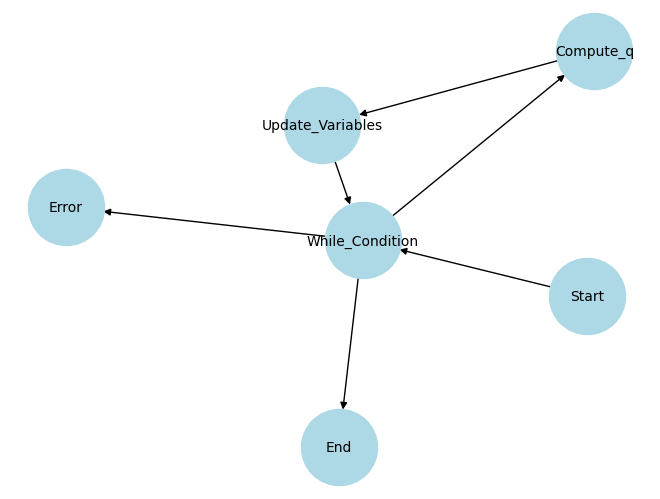

In [7]:
# Visualizar o grafo
pos = nx.spring_layout(cfa, k=1, iterations=50)
nx.draw(cfa, pos, with_labels=True, node_size=3000, font_size=10, font_color="black", node_color="lightblue")
plt.show()

#### Alinea b Verificação da segurança do programa

In [8]:
def graph_safety(G, n):
    print(f"> A testar {n} iterações.\n")

    solver = Solver()
    do = BoolVal(True)  # Estado inicial

    for i in range(1, n + 1):
        print(f"> Iteração {i}")
        clauses = []

        # Verificar todas as arestas do grafo
        for source, target, data in G.edges(data=True):
            condition = data["condition"]

            # Caso o alvo seja 'Error', verificar se é alcançável
            if target == "Error":
                solver.push()
                solver.add(And(do, condition))
                if solver.check() == "sat":  # Verifica se é possível alcançar "Error"
                    print(f"> Iteração {i}: sistema inseguro (estado 'Error').")
                    return
                solver.pop()

            # Caso seja outro estado, acumular cláusulas
            else:
                clauses.append(Implies(And(do, condition), G.nodes[target]["annotation"]))

        # Atualizar o estado
        new_do = Or(*clauses)

        # Verificar se estabilizou (não há novas mudanças)
        solver.push()
        solver.add(And(do != new_do))
        if solver.check() == "unsat":
            print(f"> Iteração {i}: sistema seguro.")
            return
        solver.pop()


    print(f"\n> Não foram encontrados estados inseguros nas {n} interações.")

# Testar segurança
graph_safety(cfa, 10)


> A testar 10 iterações.

> Iteração 1
> Iteração 2
> Iteração 3
> Iteração 4
> Iteração 5
> Iteração 6
> Iteração 7
> Iteração 8
> Iteração 9
> Iteração 10

> Não foram encontrados estados inseguros nas 10 interações.
